## 1. Import Libraries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2. Load Dataset


In [10]:
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [13]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 4. Feature Engineering



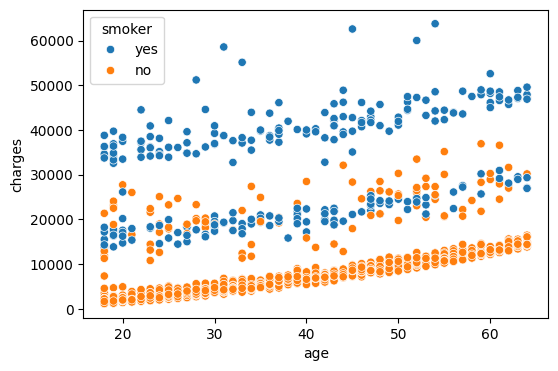

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="charges", hue="smoker", data=df)
plt.show()

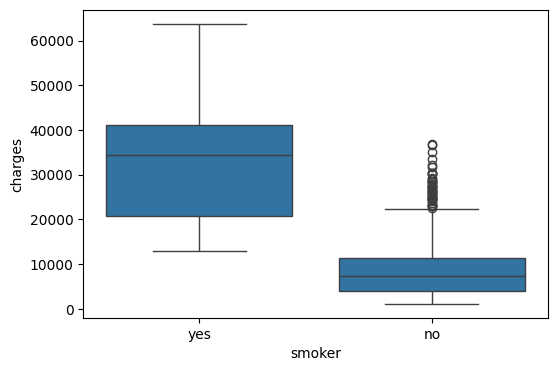

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x="smoker", y="charges", data=df)
plt.show()

In [16]:
# Interaction feature
df["age_smoker"] = df["age"] * (df["smoker"] == "yes").astype(int)

# Log transform target
df["log_charges"] = np.log(df["charges"])

In [17]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,age,bmi,children,charges,age_smoker,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,19,9.734176,False,True,False,False,True
1,18,33.770,1,1725.55230,0,7.453302,True,False,False,True,False
2,28,33.000,3,4449.46200,0,8.400538,True,False,False,True,False
3,33,22.705,0,21984.47061,0,9.998092,True,False,True,False,False
4,32,28.880,0,3866.85520,0,8.260197,True,False,True,False,False


## 5. Model Training

In [18]:
X = df_encoded.drop(["charges", "log_charges"], axis=1)
y = df_encoded["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Model Evaluation


In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [21]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2 Score"])
results_df

,Model,RMSE,R2 Score
0,Linear Regression,0.378779,0.840433
1,Ridge Regression,0.378985,0.840259
2,Lasso Regression,0.389789,0.831022
3,Gradient Boosting,0.348773,0.864712


Gradient Boosting performed best based on RMSE and R² score.

In [26]:
results_df.sort_values(by="R2 Score", ascending=False)

,Model,RMSE,R2 Score
3,Gradient Boosting,0.348773,0.864712
0,Linear Regression,0.378779,0.840433
1,Ridge Regression,0.378985,0.840259
2,Lasso Regression,0.389789,0.831022


In [22]:
gbr = GradientBoostingRegressor(random_state=42)

cv_scores = cross_val_score(
    gbr, X_train_scaled, y_train,
    cv=5, scoring="r2"
)

cv_scores.mean()

np.float64(0.8125060655717778)

In [23]:
final_model = GradientBoostingRegressor(random_state=42)
final_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [24]:
pred_log = final_model.predict(X_test_scaled)
pred_charges = np.exp(pred_log)

actual_charges = np.exp(y_test)

comparison = pd.DataFrame({
    "Actual Charges": actual_charges,
    "Predicted Charges": pred_charges
})

comparison.head()

,Actual Charges,Predicted Charges
764,9095.06825,10109.416635
887,5272.17580,5480.924303
890,29330.98315,26397.407757
1293,9301.89355,9428.806280
259,33750.29180,30469.844147


In [25]:
rmse = np.sqrt(mean_squared_error(actual_charges, pred_charges))
mae = mean_absolute_error(actual_charges, pred_charges)
r2 = r2_score(actual_charges, pred_charges)

rmse, mae, r2

(np.float64(4438.814222611737), 2050.3035505050348, 0.8730870680002671)

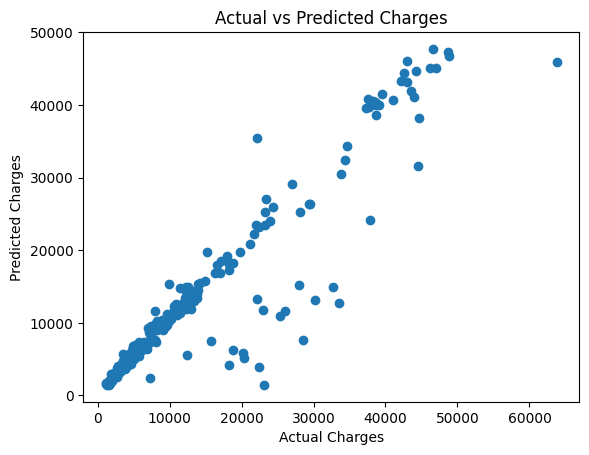

In [27]:
plt.scatter(actual_charges, pred_charges)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.show()